In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install idx2numpy

import tensorflow.keras as keras
import tensorflow as tf
import idx2numpy
import cv2 as cv
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

train_data_path = '/content/gdrive/My Drive/data9/train-images-idx3-ubyte.gz'
test_data_path = '/content/gdrive/My Drive/data9/t10k-images-idx3-ubyte.gz'
train_label_path = '/content/gdrive/My Drive/data9/train-labels-idx1-ubyte.gz'
test_label_path = '/content/gdrive/My Drive/data9/t10k-labels-idx1-ubyte.gz'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

class ResNet():

	def resnet_layer(self, inputs,
				 num_filters=16,
				 kernel_size=3,
				 strides=1,
				 activation='relu',
				 batch_normalization=True,
				 conv_first=True):

		conv = keras.layers.Conv2D(num_filters,
					  kernel_size=kernel_size,
					  strides=strides,
					  padding='same',
					  kernel_initializer='he_normal',
					  kernel_regularizer=keras.regularizers.l2(1e-4))

		x = inputs
		if conv_first:
			x = conv(x)
			if batch_normalization:
				x = keras.layers.BatchNormalization()(x)
			if activation is not None:
				x = keras.layers.Activation(activation)(x)
		else:
			if batch_normalization:
				x = keras.layers.BatchNormalization()(x)
			if activation is not None:
				x = keras.layers.Activation(activation)(x)
			x = conv(x)
		return x


	def resnet_v1(self, input_shape, depth=2, num_classes=10):
	
		if (depth - 2) % 6 != 0:
			raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
		# Start model definition.
		num_filters = 16
		num_res_blocks = int((depth - 2) / 6)

		inputs = keras.layers.Input(shape=input_shape)
		x = self.resnet_layer(inputs=inputs)
		# Instantiate the stack of residual units
		for stack in range(3):
			for res_block in range(num_res_blocks):
				strides = 1
				if stack > 0 and res_block == 0:  # first layer but not first stack
					strides = 2  # downsample
				y = self.resnet_layer(inputs=x,
								 num_filters=num_filters,
								 strides=strides)
				y = self.resnet_layer(inputs=y,
								 num_filters=num_filters,
								 activation=None)
				if stack > 0 and res_block == 0:  # first layer but not first stack
					# linear projection residual shortcut connection to match
					# changed dims
					x = self.resnet_layer(inputs=x,
									 num_filters=num_filters,
									 kernel_size=1,
									 strides=strides,
									 activation=None,
									 batch_normalization=False)
				x = keras.layers.add([x, y])
				x = keras.layers.Activation('relu')(x)
			num_filters *= 2

		# Add classifier on top.
		# v1 does not use BN after last shortcut connection-ReLU
		x = keras.layers.AveragePooling2D(pool_size=8)(x)
		y = keras.layers.Flatten()(x)
		outputs = keras.layers.Dense(num_classes,
						activation='softmax',
						kernel_initializer='he_normal')(y)

		# Instantiate model.
		model = keras.models.Model(inputs=inputs, outputs=outputs)
		return model

	def extract_data(self, filepath, num_img):
		with gzip.open(filepath) as f:
			f.read(16)
			buf = f.read(28 * 28 * num_img)
			train_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
			train_data = train_data.reshape(num_img, 28, 28, 1)
			return train_data

	def extract_labels(self, filepath, num_img):
		with gzip.open(filepath) as f:
			f.read(8)
			buf = f.read(num_img)
			labels= np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
			# labels = labels.reshape(num_img, 28, 28, 1)
			return labels


In [0]:
res = ResNet()

train_data = res.extract_data(train_data_path, 60000)
train_labels = res.extract_labels(train_label_path, 60000)
test_data = res.extract_data(test_data_path, 10000)
test_labels = res.extract_labels(test_label_path, 10000)
Res_network = res.resnet_v1(input_shape=train_data.shape[1:])


Fd =open('/content/gdrive/My Drive/data9/Network_Best_one.h5', 'w+') 
Fd.close()


In [9]:
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10 )
cs= ModelCheckpoint(filepath='/content/gdrive/My Drive/data9/Network_Best_one.h5', monitor='val_loss', save_best_only=True)
Res_network.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist = Res_network.fit(train_data, train_labels, batch_size = 170, validation_data=(test_data, test_labels), epochs=300,callbacks = [es,cs])
Res_network.save('/content/gdrive/My Drive/data9/Network_config_nona.h5')
with open('/content/gdrive/My Drive/data9/History_config_nona', 'wb') as file:
  pickle.dump(hist.history, file)


Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 2s 32us/sample - loss: 1.2026 - acc: 0.6205 - val_loss: 0.8346 - val_acc: 0.7177
Epoch 2/300
60000/60000 [==============================] - 2s 27us/sample - loss: 0.7263 - acc: 0.7445 - val_loss: 0.6950 - val_acc: 0.7479
Epoch 3/300
60000/60000 [==============================] - 2s 28us/sample - loss: 0.6330 - acc: 0.7710 - val_loss: 0.6307 - val_acc: 0.7742
Epoch 4/300
60000/60000 [==============================] - 2s 28us/sample - loss: 0.5836 - acc: 0.7870 - val_loss: 0.5866 - val_acc: 0.7859
Epoch 5/300
60000/60000 [==============================] - 2s 27us/sample - loss: 0.5519 - acc: 0.7976 - val_loss: 0.5601 - val_acc: 0.7955
Epoch 6/300
60000/60000 [==============================] - 2s 27us/sample - loss: 0.5285 - acc: 0.8063 - val_loss: 0.5442 - val_acc: 0.8040
Epoch 7/300
60000/60000 [==============================] - 2s 27us/sample - loss: 0.5124 - acc: 0.8127 - val_l

OUTPUT FROM BEST MODEL
10000/10000 - 1s - loss: 0.3744 - acc: 0.8666


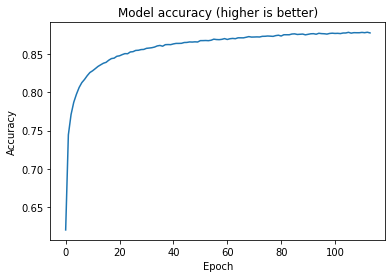

In [11]:

print("OUTPUT FROM BEST MODEL")
#Bestmodel = MiniBatch_GD()
Res_network.load_weights('/content/gdrive/My Drive/data9/Network_Best_one.h5')
oss, acc = Res_network.evaluate(test_data,  test_labels, verbose=2)



import matplotlib.pyplot as plt

plt.plot(hist.history['acc'])
plt.title('Model accuracy (higher is better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()